In [1]:
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from citrination_client import CitrinationClient
from xrsdkit.tools.citrination_tools import get_data_from_Citrination

In [2]:
from xrsdkit.models.structure_classifier import StructureClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import sklearn

In [3]:
with open("citrination_api_key_ssrl.txt", "r") as g: 
    api_key = g.readline()
a_key = api_key.strip()
client = CitrinationClient(site='https://slac.citrination.com',api_key=a_key )

In [4]:
data = get_data_from_Citrination(client = client, dataset_id_list= [21,22,23,28,29,30,31,32,33,34,35,36])

In [5]:
data.experiment_id.value_counts()

R12           306
R1            293
R3            145
R2            120
R13           103
Reaction_C     88
Reaction_A     76
Reaction_D     70
Reaction_B     65
Reaction_H     63
Reaction_E     60
Reaction_G     51
Name: experiment_id, dtype: int64

## Data Visualization

We know that we have a lot of almost dublicates - often the samples from the same experiment are about the same. I will visualize it using features and "population" column.

In [6]:
cols_to_scale = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

In [7]:
vis_data = data
vis_data[cols_to_scale] = preprocessing.scale(vis_data[cols_to_scale])

In [9]:
from sklearn.decomposition import PCA

def doPCA(data, num_of_componets):
    pca = PCA(n_components=num_of_componets)
    pca.fit(data)
    return pca

In [12]:
pca = doPCA(vis_data[cols_to_scale], 2)
transformed_data = pca.transform(vis_data[cols_to_scale])

In [13]:
vis_data['pca0'] = transformed_data[ : ,0]
vis_data['pca1'] = transformed_data[ : ,1]

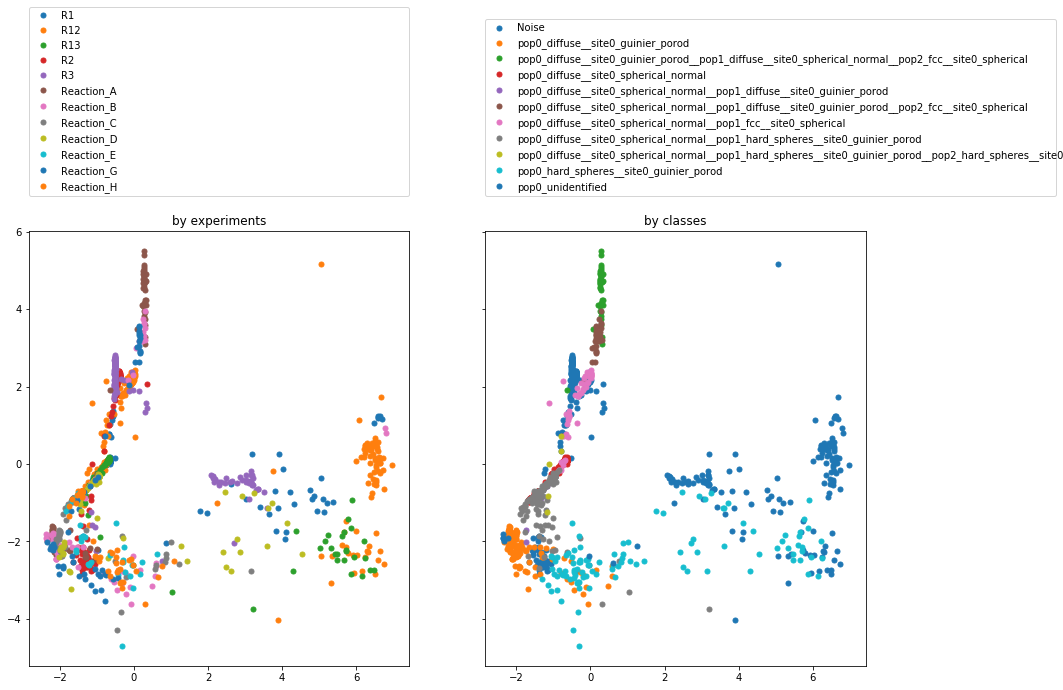

In [69]:
groups = vis_data.groupby('experiment_id')
groups2 = vis_data.groupby('system_class')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('by experiments')
ax1.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

for name, group in groups2:
    ax2.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('by classes')
ax2.legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

### Let explore the data from R12 and R1:

In [86]:
data_R12 = vis_data[vis_data['experiment_id']=='R12']
data_R12.system_class.value_counts()

Noise                                                                           145
pop0_diffuse__site0_spherical_normal                                            112
pop0_diffuse__site0_spherical_normal__pop1_fcc__site0_spherical                  40
pop0_diffuse__site0_spherical_normal__pop1_hard_spheres__site0_guinier_porod      7
pop0_hard_spheres__site0_guinier_porod                                            2
Name: system_class, dtype: int64

In [87]:
data_R1 = vis_data[vis_data['experiment_id']=='R1']
data_R1.system_class.value_counts()

pop0_diffuse__site0_spherical_normal                                            226
Noise                                                                            36
pop0_diffuse__site0_spherical_normal__pop1_fcc__site0_spherical                  14
pop0_diffuse__site0_spherical_normal__pop1_hard_spheres__site0_guinier_porod     14
pop0_hard_spheres__site0_guinier_porod                                            3
Name: system_class, dtype: int64

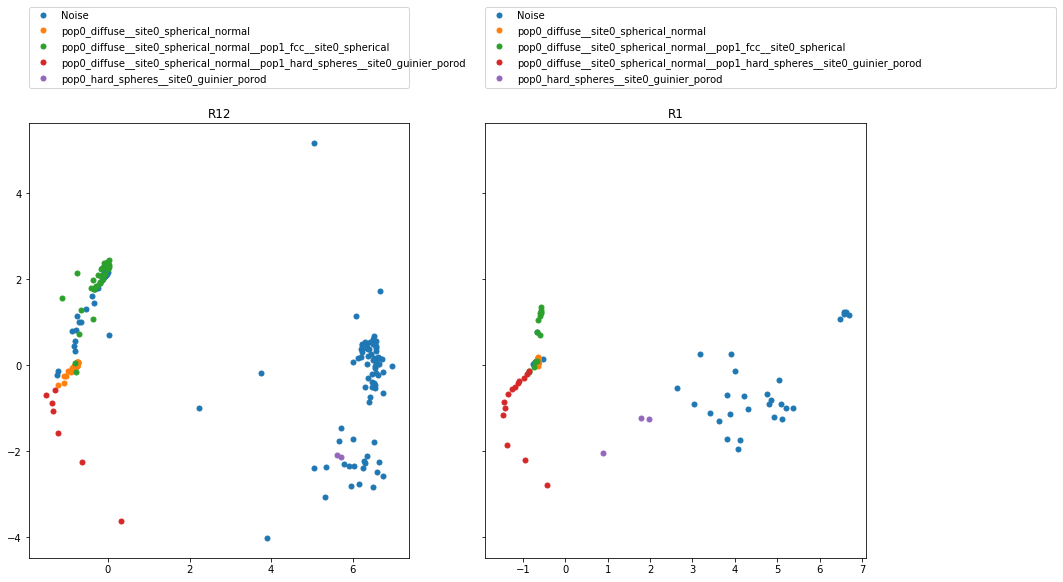

In [88]:
groups = data_R12.groupby('system_class')
groups2 = data_R1.groupby('system_class')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) 
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('R12')
ax1.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

for name, group in groups2:
    ax2.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('R1')
ax2.legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

### Goal: we want to remove the samples that are almost dublicates

In [89]:
sample_R12 = pd.DataFrame(columns=vis_data.columns)
for name, group in groups:
    df = pd.DataFrame(columns=vis_data.columns)
    df = df.append(group.iloc[0])
    for i in range(1, group.shape[0]):
        add_row = True
        for j in range(0, df.shape[0]):
            #print(group.iloc[i][cols_to_scale])
            s = sum((group.iloc[i][cols_to_scale] - group.iloc[j][cols_to_scale]).abs())
            if s < 1:
                add_row = False 
        if add_row:
            df = df.append(group.iloc[i])
    sample_R12 = sample_R12.append(df)

In [90]:
sample_R12.shape

(108, 38)

In [91]:
sample_R1 = pd.DataFrame(columns=vis_data.columns)
for name, group in groups2:
    df = pd.DataFrame(columns=vis_data.columns)
    df = df.append(group.iloc[0])
    for i in range(1, group.shape[0]):
        add_row = True
        for j in range(0, df.shape[0]):
            s = sum((group.iloc[i][cols_to_scale] - group.iloc[j][cols_to_scale]).abs())
            if s < 1:
                add_row = False 
        if add_row:
            df = df.append(group.iloc[i])
    sample_R1 = sample_R1.append(df)

In [92]:
sample_R1.shape

(50, 38)

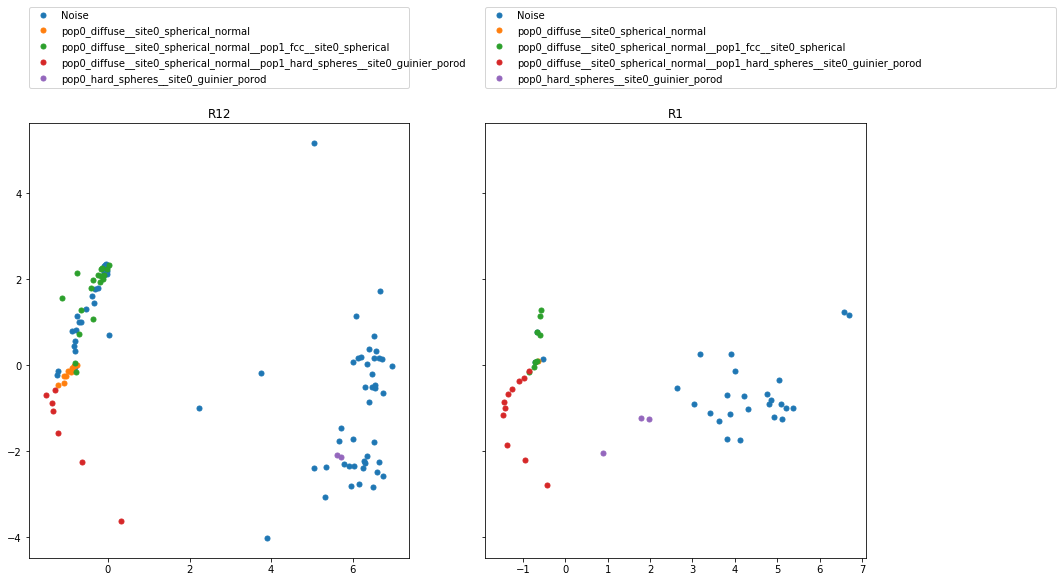

In [93]:
groups = sample_R12.groupby('system_class')
groups2 = sample_R1.groupby('system_class')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) 
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('R12')
ax1.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

for name, group in groups2:
    ax2.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('R1')
ax2.legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

### Visualize "original" and redused data side by side:
## R12

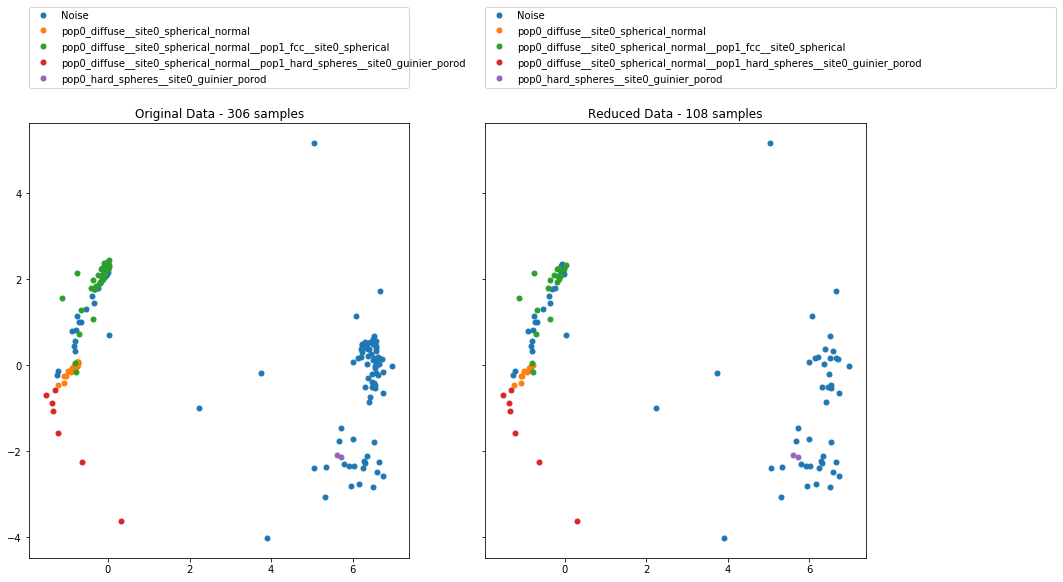

In [97]:
groups = data_R12.groupby('system_class')
groups2 = sample_R12.groupby('system_class')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) 
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('Original Data - 306 samples')
ax1.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

for name, group in groups2:
    ax2.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('Reduced Data - 108 samples')
ax2.legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

### R1

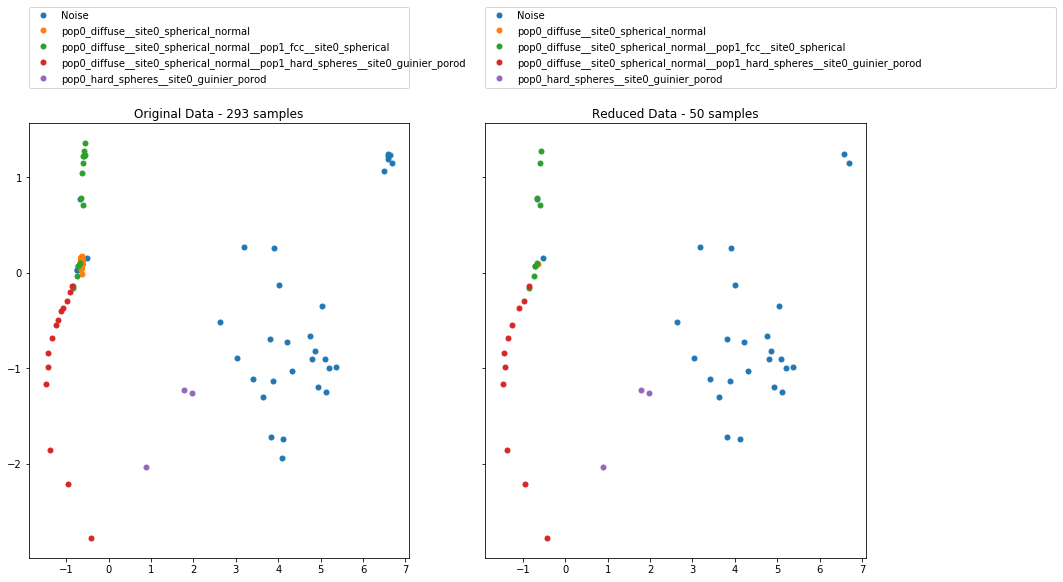

In [101]:
groups = data_R1.groupby('system_class')
groups2 = sample_R1.groupby('system_class')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) 
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('Original Data - 293 samples')
ax1.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

for name, group in groups2:
    ax2.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('Reduced Data - 50 samples')
ax2.legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()